<a href="https://colab.research.google.com/github/msommerfe/CAS_Applied_Data_Science/blob/main/CAS_Final_Project/OCR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os

In [1]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [ ]:
### Converting CHars to nums is better for ML

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 0123456789"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:

            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret



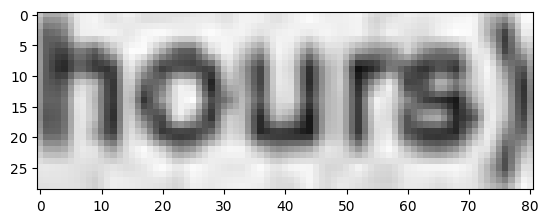

In [21]:
ImgFolder = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
imgPath = os.path.join(ImgFolder, "10.png")


plt.imshow(cv2.imread(imgPath))
plt.show()

In [34]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return final_img

image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
print(image.shape)

plt.imshow(preprocess(image))

(29, 81)


NameError: name 'cm' is not defined